In [1]:
% matplotlib inline

In [2]:
import numpy as np
import scipy
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_squared_error
from scipy.linalg import cholesky
from scipy.linalg import solve_triangular
from scipy.stats import norm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import pickle
from tqdm import tqdm

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
sns.set_style("ticks")
sns.set_style("white")
sns.set_palette(sns.color_palette("dark", 8))
plt_colors = sns.color_palette()
mpl.rcParams["xtick.direction"] = "in"
mpl.rcParams["ytick.direction"] = "in"
mpl.rcParams.update({'font.size': 12})

Code follows below.

In [5]:
np.random.seed(123)

In [14]:
fold_idx = 6

In [15]:
electrification_data = pd.read_csv("../data/electrification.csv")

In [16]:
df = pd.read_csv("../results/fold_%d/test_results.csv" % fold_idx)

In [17]:
print("Length of original test set: %d" % len(df))

Length of original test set: 17841


In [18]:
df = df.merge(electrification_data, how="inner", left_on="id", right_on="village_id")

In [19]:
df = df.loc[:,("smoothed", "true", "lat", "lng", "taluk_idx", "district_idx", "electrification")]
df = df.rename(columns={"smoothed": "pred"})

In [20]:
print("Length of merged test set: %d" % len(df))

Length of merged test set: 16680


In [21]:
print("Shape:", df.shape)

Shape: (16680, 7)


In [31]:
scipy.stats.pearsonr(df["true"], df["electrification"])

(-0.08585643433624411, 1.1452715688085204e-28)

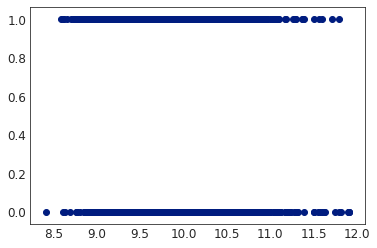

In [28]:
plt.scatter(df["true"], df["electrification"])

In [29]:
np.polyfit(df["true"], df["electrification"], deg=1)

array([-0.12442074,  1.74979868])

In [537]:
vmin = np.min(np.r_[df["true"], df["pred"]])
vmax = np.max(np.r_[df["true"], df["pred"]])

Text(0.5,1,'Predicted Expenditure')

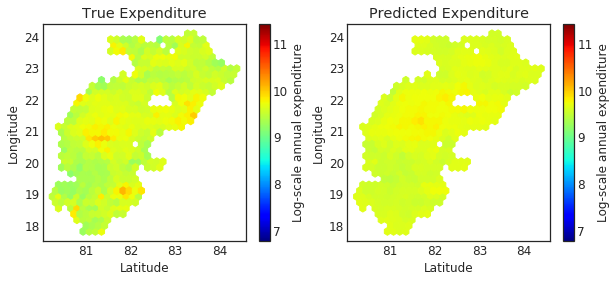

In [538]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.hexbin(df["lng"], df["lat"], C=df["true"], gridsize=30, cmap=cm.jet, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("True Expenditure")
plt.subplot(1,2,2)
plt.hexbin(df["lng"], df["lat"], C=df["pred"], gridsize=30, cmap=cm.jet, vmax=vmax, vmin=vmin, mincnt=0)
cb = plt.colorbar()
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.title("Predicted Expenditure")

Aggregate to the taluk level for computational efficiency -- there are 651 taluks.

In [539]:
df = df.groupby("taluk_idx").mean().loc[:,("pred", "true", "lat", "lng", "electrification")]

In [540]:
# df = df.loc[:,("pred", "true", "lat", "lng")]

In [541]:
print("Shape", df.shape)

Shape (61, 5)


In [542]:
idxs = np.arange(len(df))
train_idxs = np.random.choice(idxs, int(0.5 * len(idxs)), replace=False)
val_idxs = np.array(list(set(idxs) - set(train_idxs)))

In [543]:
df_train = df.iloc[train_idxs,:]
df_val = df.iloc[val_idxs,:]

In [544]:
len(df_train), len(df_val)

(30, 31)

Text(0,0.5,'Latitude')

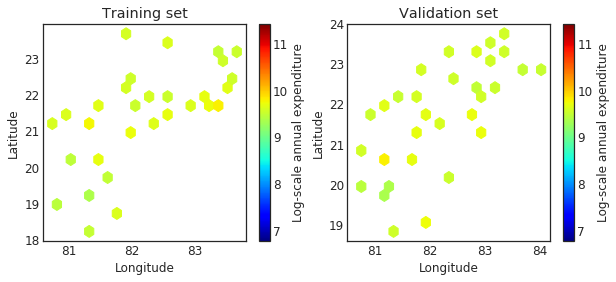

In [545]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
hb = plt.hexbin(df_train["lng"], df_train["lat"], gridsize=20, C=df_train["true"], cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Training set")
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.subplot(1,2,2)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=20, C=df_val["true"], cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Validation set")
cb.set_label("Log-scale annual expenditure")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

#### 1(a). Oracle: regress using (lat, lng) with all data points

In [546]:
gbm = GradientBoostingRegressor(n_estimators=300)
gbm.fit(df_train.loc[:,("lat", "lng")], df_train["true"]);

In [547]:
"R2 all training pts, loc only: %.3f" % r2_score(df_val["true"], gbm.predict(df_val.loc[:,("lat", "lng")]))

'R2 all training pts, loc only: 0.296'

#### 1(b). Oracle: using (lat, lng, pred) with all data points

In [548]:
gp = GradientBoostingRegressor()
gp.fit(df_train.loc[:,("lat", "lng", "pred")], df_train["true"])
mean = gp.predict(df_val.loc[:,("lat", "lng", "pred")])

In [549]:
print("R2 all training pts: %.3f" % r2_score(df_val["true"], mean))

R2 all training pts: 0.574


In [550]:
kernel = WhiteKernel() + \
         ConstantKernel() * \
         RBF(length_scale_bounds=(1e-3, 1000)) + \
         RBF(length_scale_bounds=(1e-3, 1000))

In [551]:
df_train = df.iloc[train_idxs,:]
df_val = df.iloc[val_idxs,:]

In [552]:
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(df_train.loc[:,("lat", "lng")], df_train["true"] - df_train["pred"])
preds = gp.predict(df_val.loc[:, ("lat", "lng")]) + df_val["pred"]

In [553]:
print("R2 all training pts, GP: %.3f" % r2_score(df_val["true"], preds))

R2 all training pts, GP: 0.450


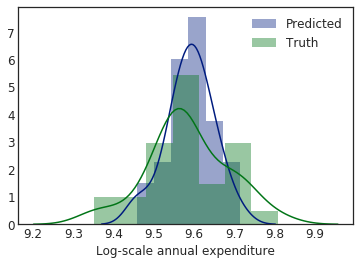

In [554]:
sns.distplot(preds, label="Predicted")
sns.distplot(df_val["true"], label="Truth")
plt.xlabel("Log-scale annual expenditure")
plt.legend()

Text(0.5,0,'Longitude')

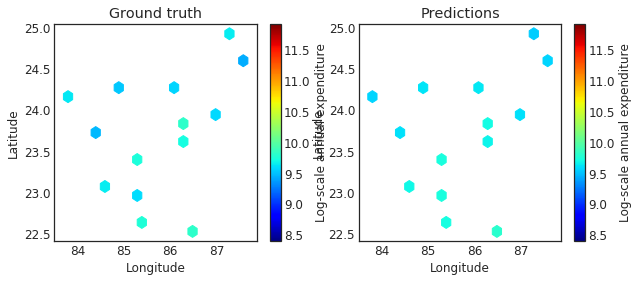

In [484]:
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=20, C=df_val["true"], cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Ground truth")
cb.set_label("Log-scale annual expenditure")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.subplot(1,2,2)
hb = plt.hexbin(df_val["lng"], df_val["lat"], gridsize=20, C=preds, cmap=cm.jet, vmax=vmax, vmin=vmin)
cb = plt.colorbar()
plt.title("Predictions")
cb.set_label("Log-scale annual expenditure")
plt.ylabel("Latitude")
plt.xlabel("Longitude")

#### 2. Baseline: regress using satellite preds only with all data points

In [151]:
lm = LinearRegression()
lm.fit(df_train.loc[:,("pred")].values.reshape(-1,1), df_train["true"]);

In [152]:
print("R2 satellite only: %.3f" % r2_score(df_val["true"], df_val["pred"]))
print("R2 satellite only, LM: %.3f" % r2_score(df_val["true"], lm.predict(df_val.loc[:,("pred")].values.reshape(-1,1))))

R2 satellite only: -0.530
R2 satellite only, LM: 0.237


#### 3. Comparison: randomly pick 20 points and use (satellite data + lat + lng)

In [601]:
bootstrap_r2s = []
for i in tqdm(range(100)):
  sampled_idxs = np.random.choice(np.arange(len(df_train)), 20, replace=False)
  df_sampled = df_train.iloc[sampled_idxs]
  gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
  gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])
  r2 = r2_score(df_val["true"], df_val["pred"] + gp.predict(df_val.loc[:,("lat", "lng")]))
  bootstrap_r2s.append(r2)

100%|██████████| 100/100 [00:11<00:00,  8.43it/s]


In [602]:
"R2 20 random samples -- 95%% CI: [%.3f %.3f]" % tuple(np.percentile(bootstrap_r2s, (2.5, 97.5)))

'R2 20 random samples -- 95% CI: [0.348 0.550]'

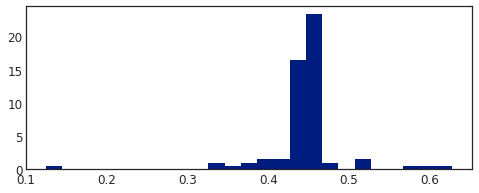

In [603]:
plt.figure(figsize=(8, 3))
plt.hist(bootstrap_r2s, bins=25, density=True);

#### 4. GP: greedily pick 20 points and use (satellite data + lat + lng)

In [284]:
def greedy_selection(init_kernel, n_samples, X, y, chol_inv=True):
  
  remaining_indices = set(np.arange(len(X)))
  picked_indices = set()

  first_pick = np.random.randint(0, len(X))
  picked_indices.add(first_pick)
  remaining_indices.remove(first_pick)

  greedy_order = [first_pick]
  
  for i in tqdm(range(n_samples - 1)):

    gp = GaussianProcessRegressor(kernel=init_kernel, normalize_y=True)
    
    # Fit the GP with the points we've sampled so far
    # this does likelihood maximization to find kernel hyperparameters 
    # in addition to doing GP regression
    gp.fit(X[np.array(sorted(list(picked_indices)))], y[np.array(sorted(list(picked_indices)))])
    
    # This is kernel with ML estimates for hyperparams
    kernel = gp.kernel_
    
    # Compute the variance at the points that are available to sample
    var_y = np.diag(kernel(X[np.array(sorted(list(remaining_indices))),:]))

    # Find the covariance matrix for the sampled points and invert
    cov_AA = kernel(X[np.array(sorted(list(picked_indices)))])
    if chol_inv:
      chol = cholesky(cov_AA)
      inv_chol = scipy.linalg.solve_triangular(chol, np.identity(chol.shape[0]))
      inv_cov_AA = np.dot(inv_chol,np.transpose(inv_chol))
    else:
      inv_cov_AA = np.linalg.inv(cov_AA)

    # Find the kernel matrix of the picked points wrt remaining points
    cov_Ay = kernel(X[np.array(sorted(list(picked_indices)))], X[np.array(sorted(list(remaining_indices)))])
    cov_yA = np.transpose(cov_Ay)

    # Run the selection procedure over the remaining indices 
    # (note it is possible to speed this up: there is a section in the 
    # paper on speeding up this process for large numbers of points)
    max_delta_j, greedy_idx = float("-inf"), -1
    
    for idx, j in enumerate(sorted(list(remaining_indices))):
      
      cov_AbarAbar = kernel(X[np.array(sorted(list(remaining_indices - set([j])))),:])
      if chol_inv:
        chol = np.linalg.cholesky(cov_AbarAbar)
        inv_chol = scipy.linalg.solve_triangular(chol, np.identity(chol.shape[0]))
        inv_cov_AbarAbar = np.dot(inv_chol,np.transpose(inv_chol))
      else:
        inv_cov_AbarAbar = np.linalg.inv(cov_AbarAbar)

      cov_Abary = kernel(X[np.array(sorted(list(remaining_indices - set([j]))))], X[j,:][np.newaxis,:])
      cov_yAbar = np.transpose(cov_Abary)
      delta_j = (var_y[idx] - np.dot(np.dot(cov_yA[idx,:][np.newaxis,:],inv_cov_AA),
                                     cov_Ay[:,idx][:,np.newaxis]))/(var_y[idx] - np.dot(np.dot(cov_yAbar,inv_cov_AbarAbar),cov_Abary))
      delta_j = delta_j.flatten()[0]

      if delta_j > max_delta_j:
        max_delta_j = delta_j
        greedy_idx = j

    picked_indices.add(greedy_idx)
    remaining_indices.remove(greedy_idx)
    greedy_order.append(greedy_idx)
    
  return greedy_order

In [285]:
kernel = WhiteKernel() + \
         ConstantKernel() * \
         RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1000)) + \
         RBF(length_scale=1.0, length_scale_bounds=(1e-3, 1000))

In [301]:
anisotropic_kernel = WhiteKernel() + \
                     ConstantKernel() * \
                     RBF(length_scale=(1.0, 1.0, 1.0), length_scale_bounds=(1e-3, 1000)) + \
                     RBF(length_scale=(1.0, 1.0, 1.0), length_scale_bounds=(1e-3, 1000))

Experiments to test out functionality below...

In [302]:
idxs = greedy_selection(
  anisotropic_kernel, 20,
  df_train.loc[:,("lat", "lng", "pred")].as_matrix(),
  np.array(df_train["true"] - df_train["pred"]), chol_inv=False)

100%|██████████| 19/19 [00:07<00:00,  2.66it/s]


In [288]:
idxs_nosat = greedy_selection(
  kernel, 20, 
  df_train.loc[:,("lat", "lng")].as_matrix(),
  np.array(df_train["true"] - df_train["pred"]), chol_inv=False)

100%|██████████| 19/19 [00:02<00:00,  6.63it/s]


In [289]:
df_sampled = df_train.iloc[np.array(idxs[:8]),:]

In [290]:
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=WhiteKernel(noise_level=1) + 1**2 * RBF(length_scale=1) + RBF(length_scale=1),
             n_restarts_optimizer=0, normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [291]:
mean, std = gp.predict(df_val.loc[:,("lat", "lng",)], return_std=True)

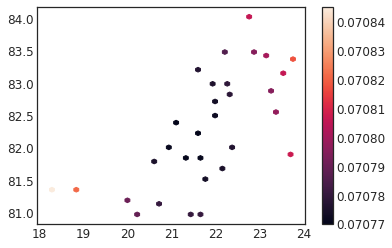

In [292]:
plt.figure(figsize=(6,4))
plt.hexbin(df_val["lat"], df_val["lng"], C=std, gridsize=50)
cb = plt.colorbar()

Text(0.5,1,'Train set')

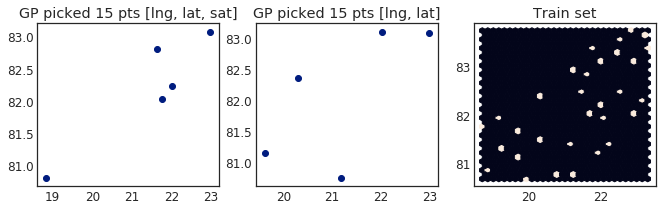

In [295]:
plt.figure(figsize=(15, 3))
plt.subplot(1,4,1)
df_sampled = df_train.iloc[idxs[:5],:]
plt.scatter(df_sampled["lat"], df_sampled["lng"])
plt.title("GP picked 15 pts [lng, lat, sat]")
plt.subplot(1,4,2)
df_sampled = df_train.iloc[idxs_nosat[:5],:]
plt.scatter(df_sampled["lat"], df_sampled["lng"])
plt.title("GP picked 15 pts [lng, lat]")
plt.subplot(1,4,3)
plt.hexbin(df_train["lat"], df_train["lng"], gridsize=30)
plt.title("Train set")

In [589]:
class SamplingLogger(object):
  
  def __init__(self, name):
    self.name = name
    self.r2s_matrix = []
    self.mses_matrix = []
    self.coeffs_matrix = []
    self.r2s = []
    self.mses = []
    self.coeffs = []

  def tick(self, df_sampled, df_val, preds):
    self.r2s.append(r2_score(df_val["true"], preds))
    self.mses.append(mean_squared_error(df_val["true"], preds))
    preds = np.r_[preds, df_sampled["true"]]
    elec = np.r_[df_val["electrification"], df_sampled["electrification"]]
    self.coeffs.append(np.polyfit(preds, elec, deg=1)[0])
    
  def clear_run(self):
    if self.r2s:
      self.r2s_matrix.append(self.r2s)
    if self.mses:
      self.mses_matrix.append(self.mses)
    if self.coeffs:
      self.coeffs_matrix.append(self.coeffs)
    self.r2s = []
    self.mses = []
    self.coeffs = []
    
  def save(self, fold_idx):
    pickle.dump(self, open("../results/fold_%d/sampling_%s.pkl" % (fold_idx, self.name), "wb"))

In [597]:
def sample_greedy_with_sat(df_train, df_val, n_reps=3):
  """
  Sample greedily, building on top of satellite predictions.
  """
  logger = SamplingLogger("greedy_sat")
  for _ in range(n_reps):
    idxs = greedy_selection(
      anisotropic_kernel, len(df_train) - 1, 
      df_train.loc[:,("lat", "lng", "pred")].as_matrix(),
      np.array(df_train["true"] - df_train["pred"]), chol_inv=False)
    for i in tqdm(range(1, len(idxs) + 1)):
      df_sampled = df_train.iloc[idxs[:i],:]
      gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
      gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])
      preds = gp.predict(df_val.loc[:,("lat", "lng")]) + df_val["pred"]
      logger.tick(df_sampled, df_val, preds)
    logger.clear_run()
  return logger

In [598]:
def sample_greedy_no_sat(df_train, df_val, n_reps=3):
  """
  Sample greedily, without building on satellite predictions.
  """
  logger = SamplingLogger("greedy_nosat")
  for _ in range(n_reps):
    idxs = greedy_selection(
      kernel, len(df_train) - 1, 
      df_train.loc[:,("lat", "lng")].as_matrix(),
      np.array(df_train["true"]), chol_inv=False)
    for i in tqdm(range(1, len(idxs) + 1)):
      df_sampled = df_train.iloc[idxs[:i],:]
      gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
      gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"])
      preds = gp.predict(df_val.loc[:,("lat", "lng")])
      logger.tick(df_sampled, df_val, preds)
    logger.clear_run()
  return logger

In [599]:
def sample_random_with_sat(df_train, df_val, n_reps=5):
  """
  Randomly sample, building on top of satellite predictions.
  """
  logger = SamplingLogger("random_sat")
  for _ in range(n_reps):
    idxs_random = np.arange(len(df_train))
    np.random.shuffle(idxs_random)
    for i in tqdm(range(1, len(df_train))):
      df_sampled = df_train.iloc[idxs_random[:i],:]
      gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
      gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"] - df_sampled["pred"])
      preds = df_val["pred"] + gp.predict(df_val.loc[:,("lat", "lng")])
      logger.tick(df_sampled, df_val, preds)
    logger.clear_run()
  return logger

In [600]:
def sample_random_no_sat(df_train, df_val, n_reps=5):
  """
  Randomly sample, without building on top of satellite predictions.
  """
  logger = SamplingLogger("random_nosat")
  for _ in range(n_reps):
    idxs_random = np.arange(len(df_train))
    np.random.shuffle(idxs_random)
    for i in tqdm(range(1, len(df_train))):
      df_sampled = df_train.iloc[idxs_random[:i],:]
      gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
      gp.fit(df_sampled.loc[:,("lat", "lng")], df_sampled["true"])
      preds = gp.predict(df_val.loc[:,("lat", "lng")])
      logger.tick(df_sampled, df_val, preds)
  return logger

In [590]:
logs = sample_random_with_sat(df_train, df_val)

100%|██████████| 29/29 [00:03<00:00,  8.64it/s]


In [592]:
logs.save(4)

In [342]:
new, _ = sample_random_with_sat(df_train, df_val)

100%|██████████| 30/30 [00:03<00:00,  9.28it/s]


In [ ]:
pd.to_csv("../results/fold_%d/sampling_train.csv" % fold_idx, df_train)
pd.to_csv("../results/fold_%d/sampling_val.csv" % fold_idx, df_val)

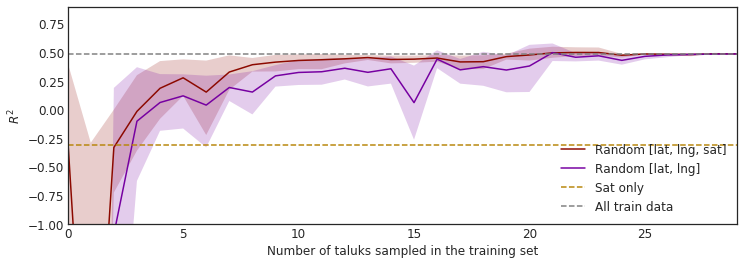

In [343]:
plt.figure(figsize=(12, 4))
sns.tsplot(a, condition="Greedy GP [lat, lng, sat]", color=plt_colors[0], ci=95)
sns.tsplot(c, condition="Greedy GP [lat, lng]", color=plt_colors[1], ci=95)
sns.tsplot(new, condition="Random [lat, lng, sat]", color=plt_colors[2], ci=95)
sns.tsplot(bkup, condition="Random [lat, lng]", color=plt_colors[3], ci=95)
plt.xlabel("Number of taluks sampled in the training set")
plt.ylabel("$R^2$")
plt.axhline(r2_score(df_val["true"], df_val["pred"]), ls="--", color=plt_colors[4], label="Sat only")
plt.axhline(r2_score(df_val["true"], preds), ls="--", color="grey", label="All train data")
plt.ylim(-1, 0.9)
plt.legend();

In [581]:
np.polyfit(df_val["true"], df_val["electrification"], deg=1)

array([-0.18290039,  1.94627982])

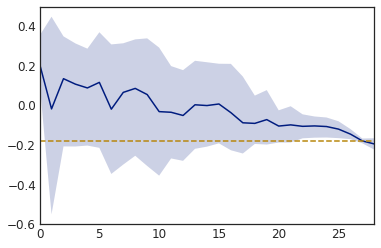

In [606]:
sns.tsplot(logs.coeffs_matrix, ci=95)
plt.axhline(-0.18290039, ls="--", color=plt_colors[4], label="Sat only")